# 0. Install and Import Dependencies

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio.v3 as iio
import gdown

In [2]:
# try to set GPU for training if available on device

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [3]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Download dataset and Build Data Loading Functions

In [4]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=e4872761-c8af-4e82-aab7-92c1c41a933b
To: /tf/data.zip
100%|██████████| 423M/423M [00:15<00:00, 27.5MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [5]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) #manually cut lip part from video frame
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "] #vocab for training

In [7]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [9]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [11]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [12]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [14]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [16]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [17]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split
train = data.take(450)
test = data.skip(450)

In [18]:
len(test)

50

In [19]:
frames, alignments = data.as_numpy_iterator().next()

In [20]:
len(frames)

2

In [21]:
sample = data.as_numpy_iterator()

In [22]:
val = sample.next(); val[0]

array([[[[[ 1.1997304 ],
          [ 1.1997304 ],
          [ 1.1997304 ],
          ...,
          [ 0.71983826],
          [ 0.6398562 ],
          [ 0.5598742 ]],

         [[ 1.1997304 ],
          [ 1.1997304 ],
          [ 1.1997304 ],
          ...,
          [ 0.67984724],
          [ 0.6398562 ],
          [ 0.5598742 ]],

         [[ 1.1597394 ],
          [ 1.1597394 ],
          [ 1.1597394 ],
          ...,
          [ 0.67984724],
          [ 0.5198832 ],
          [ 0.3199281 ]],

         ...,

         [[ 0.7598293 ],
          [ 0.7598293 ],
          [ 0.7598293 ],
          ...,
          [ 0.8398113 ],
          [ 0.9197933 ],
          [ 0.99977535]],

         [[ 0.71983826],
          [ 0.71983826],
          [ 0.71983826],
          ...,
          [ 0.8398113 ],
          [ 0.6398562 ],
          [ 0.9597843 ]],

         [[ 0.71983826],
          [ 0.71983826],
          [ 0.71983826],
          ...,
          [ 0.7998203 ],
          [ 0.67984724],
          

In [23]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [24]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green by r zero now'>

# 3. Design the Deep Neural Network

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv3D, LSTM, Dense, Dropout,Add, Bidirectional,LayerNormalization, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten, Lambda,MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.initializers import Orthogonal
from tensorflow.keras.models import Model

In [26]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [27]:
# Input layer
inputs = Input(shape=(75, 46, 140, 1))

# Convolutional layers
x = Conv3D(128, 3, padding='same')(inputs)
x = Activation('relu')(x)
x = MaxPool3D((1, 2, 2))(x)

x = Conv3D(256, 3, padding='same')(x)
x = Activation('relu')(x)
x = MaxPool3D((1, 2, 2))(x)

x = Conv3D(75, 3, padding='same')(x)
x = Activation('relu')(x)
x = MaxPool3D((1, 2, 2))(x)

# Reshape before TimeDistributed
output_size = 5 * 17 * 75
x = Reshape((-1, output_size))(x)

# Flatten for each time step
x = TimeDistributed(Flatten())(x)

# Bidirectional LSTM layers
x = Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True))(x)
x = Dropout(0.5)(x)

x = Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True))(x)
x = Dropout(0.5)(x)

# Transformer Layer
# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=8, key_dim=128)(x, x)
attention_output = Add()([x, attention_output])  # Residual connection
attention_output = LayerNormalization()(attention_output)

# Feed-forward network with residual connection
ffn_output = Dense(512, activation='relu')(attention_output)
ffn_output = Dense(256)(ffn_output)
x = Add()([attention_output, ffn_output])  # Residual connection
x = LayerNormalization()(x)

# Output layer
outputs = Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax')(x)

# Define the model
model = Model(inputs, outputs)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 46, 140  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d (Conv3D)                (None, 75, 46, 140,  3584        ['input_1[0][0]']                
                                 128)                                                             
                                                                                                  
 activation (Activation)        (None, 75, 46, 140,  0           ['conv3d[0][0]']                 
                                 128)                                                         

In [29]:
# Predict to check for any error
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [30]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'eeeeffffffffffffffffffffffeeeeefffeeeeeefffeeeeeeeeeeeeeeeeeeeeeeeeeeeeffff'>

In [31]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'eeeeffffffffffffffffffffffeeeeefffeeeeeefffeeeeeeeeeeeeeeeeeeeeeeeeeeeeffff'>

In [32]:
model.input_shape

(None, 75, 46, 140, 1)

In [33]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [34]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [35]:
# CTC Loss function 
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [36]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)
        prev_epoch +=1

In [37]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [38]:
checkpoint_callback = ModelCheckpoint(os.path.join('checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [39]:
schedule_callback = LearningRateScheduler(scheduler)

In [40]:
example_callback = ProduceExample(test)

In [41]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

<span style="color:red; font-size:20px;">Note:</span> The model is trained backstage with a GPU, and several images from the training process are attached below. For evaluation purposes, we ran the 100th final epoch from the 99th model checkpoint below.


`Epoch 1-3`
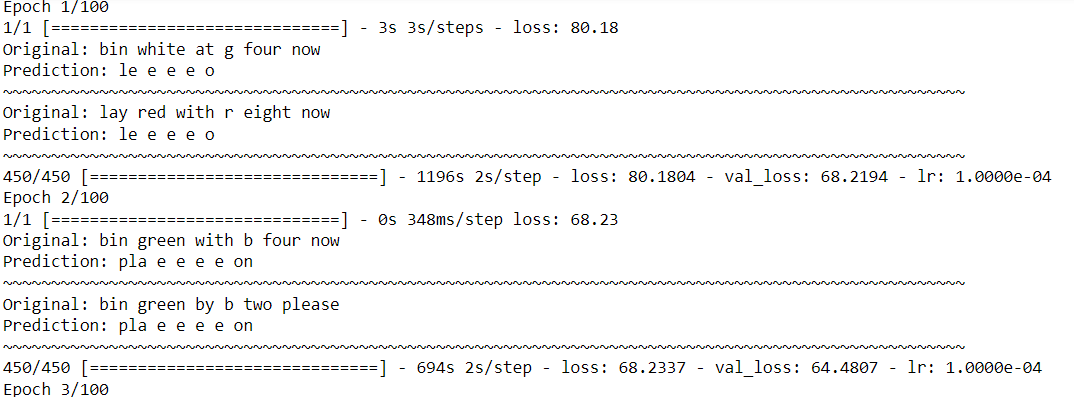


`Epoch 13-20`
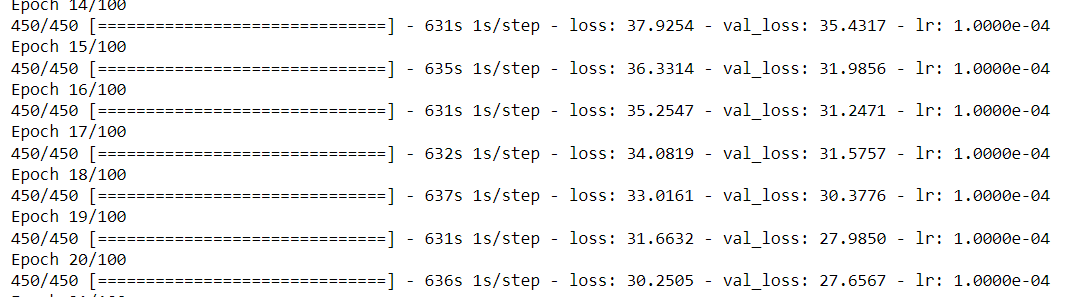

`Epoch 33-36`
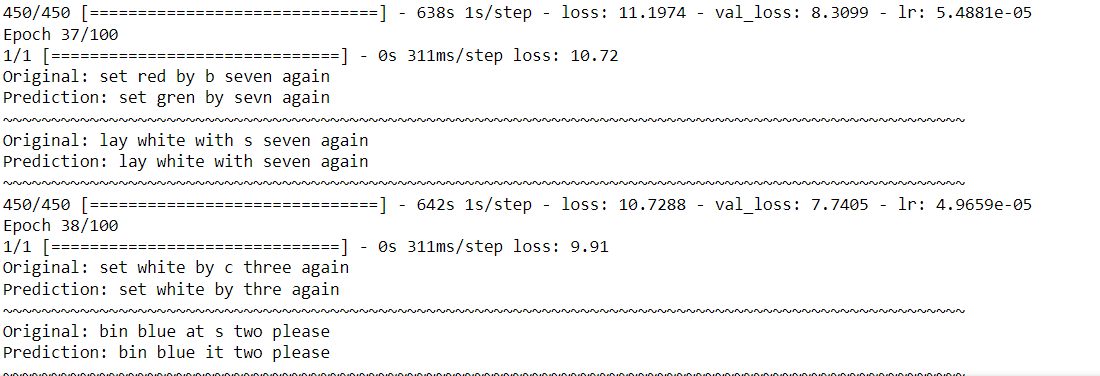

In [42]:
# model.fit(train,validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [43]:

#  Load weights from the checkpoint file
checkpoint_path = '100_checkpoint.weights.h5'
model.load_weights(checkpoint_path)

#  Resume training from epoch 99 onwards
initial_epoch = 99
model.fit(train,
          validation_data=test,
          epochs=100,
          initial_epoch=initial_epoch,
          batch_size=2,
          callbacks=[checkpoint_callback, schedule_callback])

Epoch 100/100
450/450 [==============================] - 914s 1s/step - loss: 3.8185 - val_loss: 1.8564 - lr: 9.0484e-05


# Predict on a Video

In [44]:
sample = load_data(tf.convert_to_tensor('/data/s1/bras9a.mpg'))

In [45]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [46]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [47]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [48]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

## Results

The below comparision graph data is extracted from paper and our training `manually`. 

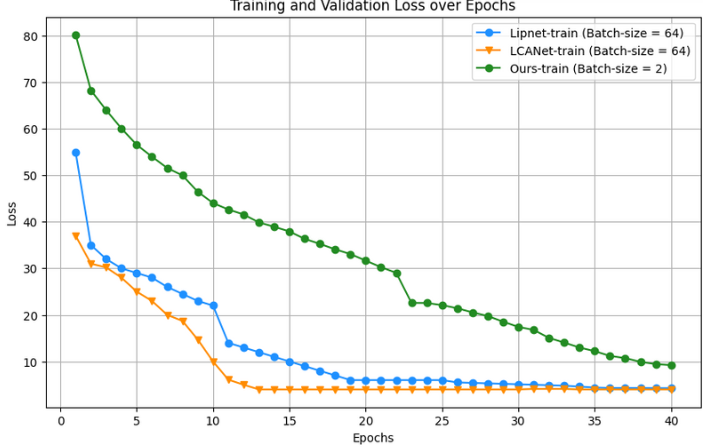

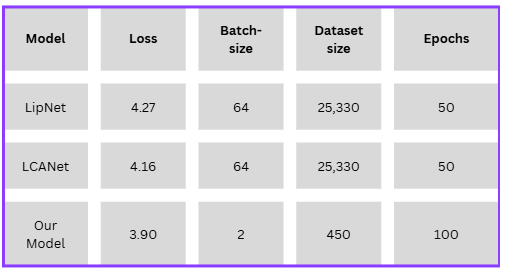

## WER and CER calculation

In [49]:
import os
import numpy as np
from jiwer import wer
from difflib import SequenceMatcher

def load_and_predict(video_path, model):
    # Load the video sample and make predictions
    sample = load_data(tf.convert_to_tensor(video_path))
    real_text = tf.strings.reduce_join([num_to_char(word) for word in sample[1]]).numpy().decode("utf-8")
    
    yhat = model.predict(tf.expand_dims(sample[0], axis=0))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    predicted_text = tf.strings.reduce_join([num_to_char(word) for word in decoded]).numpy().decode("utf-8")
    
    return real_text, predicted_text

def calculate_wer(real_text, predicted_text):
    return wer(real_text, predicted_text)

def calculate_cer(real_text, predicted_text):
    # Compute Character Error Rate (CER) using Levenshtein distance at the character level
    matcher = SequenceMatcher(None, real_text, predicted_text)
    return 1 - matcher.ratio()  # CER is the normalized distance (1 - similarity)

# Specify the folder containing the videos
video_folder = '/tf/data/s1'

# Initialize variables to accumulate WER and CER values
total_wer = 0.0
total_cer = 0.0
file_count = 0

# Iterate through all video files in the folder
for filename in os.listdir(video_folder):
    try:
        if filename.endswith(".mpg") :
            video_path = os.path.join(video_folder, filename)

            # Load video and get the predictions
            real_text, predicted_text = load_and_predict(video_path, model)

            # Calculate WER and CER
            wer_value = calculate_wer(real_text, predicted_text)
            cer_value = calculate_cer(real_text, predicted_text)

            # Accumulate WER and CER for averaging
            total_wer += wer_value
            total_cer += cer_value
            file_count += 1

            # Print individual video results
            print(f"Video: {filename}")
            print("Real Text:", real_text)
            print("Predicted Text:", predicted_text)
            print("WER:", wer_value)
            print("CER:", cer_value)
            print("~" * 100)
    except:
        pass

# Calculate and print the average WER and CER across all videos
average_wer = total_wer / file_count if file_count > 0 else 0
average_cer = total_cer / file_count if file_count > 0 else 0

print("Average WER across all videos:", average_wer)
print("Average CER across all videos:", average_cer)


1/1 [==============================] - 0s 165ms/step
Video: bwat2n.mpg
Real Text: bin white at t two now
Predicted Text: bin white at t two now
WER: 0.0
CER: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 164ms/step
Video: bwanzp.mpg
Real Text: bin white at n zero please
Predicted Text: bin white at n zero please
WER: 0.0
CER: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 163ms/step
Video: lwwf7s.mpg
Real Text: lay white with f seven soon
Predicted Text: lay white with z seven soon
WER: 0.16666666666666666
CER: 0.03703703703703709
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 164ms/step
Video: brbazp.mpg
Real Text: bin red by a zero please
Predicted Text: bin red by a zero please
WER: 0.0
CER: